In [1]:
import os
from src.dataPipeline import DataPipeline

os.chdir('..')

dp = DataPipeline()
df = dp.runPipeline(normalizeAndStandardize=True)

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:39: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

In [2]:
class StandardizeTransform:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, x):
        return (x - self.mean) / self.std

    def inverse(self, x):
        return x * self.std + self.mean

In [3]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error


y = df['price_cleaned']
y = np.log(y)

X = df.drop(columns=['price_cleaned'])


# Set up K-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mapes = []
models = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = Lasso(alpha=0.001, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_pred = np.exp(y_pred)
    y_test = np.exp(y_test)
    
    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    mapes.append(mape)
    models.append(model)
    print(f'MAPE: {mape:.2f}%')

# Durchschnittlicher MAPE
average_mape = np.mean(mapes)
print(f'Durchschnittlicher MAPE über K-Folds: {average_mape:.2f}%')


MAPE: 460.40%
MAPE: 47.76%
MAPE: 72.29%
MAPE: 148.04%
MAPE: 85.59%
MAPE: 116.75%
MAPE: 95.39%
MAPE: 121.24%
MAPE: 94.14%
MAPE: 332.65%
Durchschnittlicher MAPE über K-Folds: 157.43%


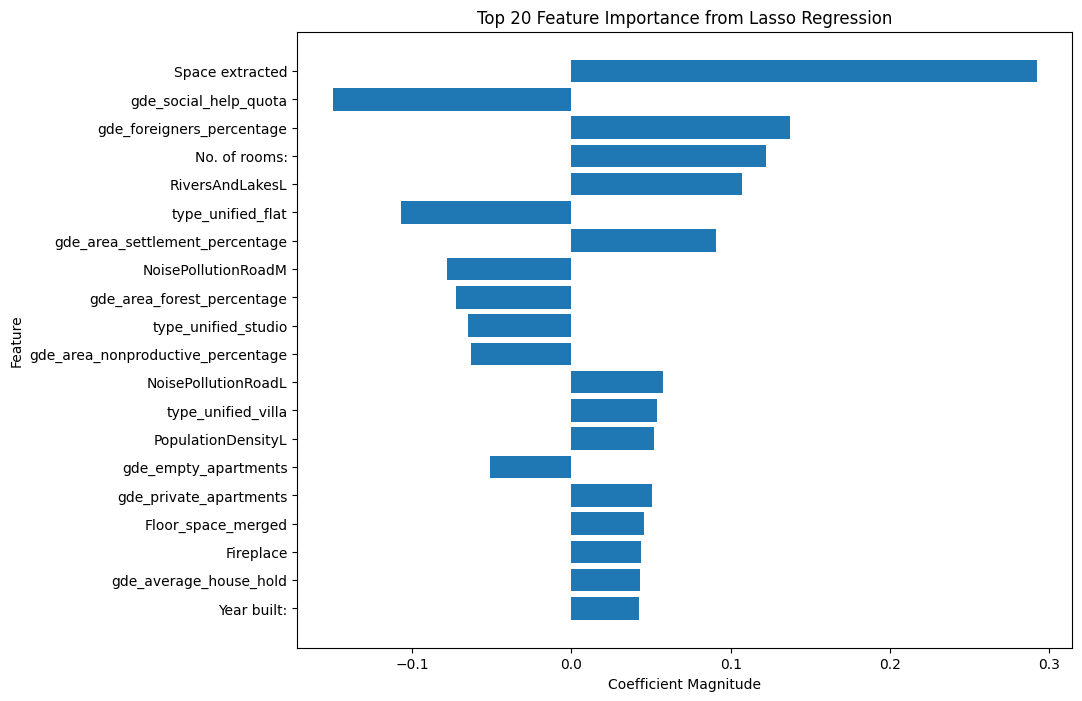

In [4]:
# Collect coefficients from each model
import pandas as pd
import matplotlib.pyplot as plt

coefs = np.array([model.coef_ for model in models])

# Calculate the mean coefficient (importance) across folds
mean_coefs = np.mean(coefs, axis=0)


feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': mean_coefs
}).sort_values(by='Importance', ascending=False)

# Create a DataFrame for easier plotting
# Select the top 20 features with the highest absolute coefficient magnitude
top_features = feature_importance.reindex(feature_importance['Importance'].abs().nlargest(20).index)

# Plot feature importance for the top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance from Lasso Regression')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


C:\FHNW_Programmiersachen\5_Sem\immo_challenge\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1971981.089151371, tolerance: 395.1062105927858
  model = cd_fast.enet_coordinate_descent_gram(


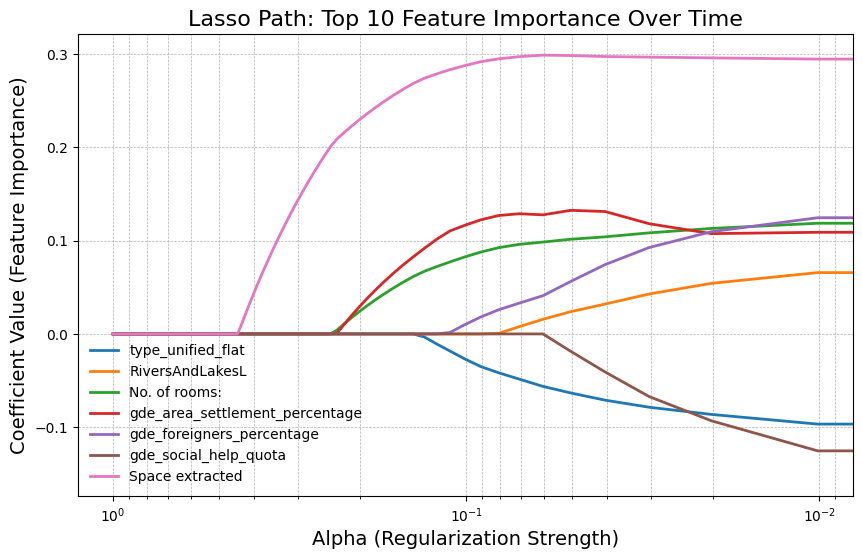

In [5]:
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
import numpy as np

# Calculate the Lasso path
alphas, coefs, _ = lasso_path(X, y, alphas=np.linspace(1, 0, 100))

# Determine the top 10 features based on maximum absolute coefficient magnitude
max_coef_magnitudes = np.max(np.abs(coefs), axis=1)  # Max coefficient magnitude for each feature
top_10_indices = np.argsort(max_coef_magnitudes)[-7:]  # Indices of top 10 features

# Plotting
plt.figure(figsize=(10, 6))

# Plot only the top 10 feature paths
for i in top_10_indices:
    plt.plot(alphas, coefs[i], label=X.columns[i], linewidth=2)

# Enhancements for readability and aesthetics
plt.xscale('log')              # Use a logarithmic scale for alpha
plt.gca().invert_xaxis()        # Invert the x-axis
plt.xlabel('Alpha (Regularization Strength)', fontsize=14)
plt.ylabel('Coefficient Value (Feature Importance)', fontsize=14)
plt.title('Lasso Path: Top 10 Feature Importance Over Time', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for better readability
plt.legend(loc='best', fontsize=10, frameon=False)

plt.show()
